<div style="display: flex; background-color: RGB(255,114,0);" >

# PROJET - Logement </h1>
</div>

**Votre tâche consiste à prédire les valeurs médianes des maisons dans les quartiers californiens, compte tenu d'un certain nombre de caractéristiques de ces les quartiers. (Pour une meilleure évaluation en utilisant "Pipeline", "Evaluation Cross-validation", "Grid search" ...**

Données : https://www.kaggle.com/camnugent/california-housing-prices

About this file

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from os import getcwd
import matplotlib.image as mpimg
from function import *

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

print("Chargement des données...")
# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

Chargement des données...


'c:\\Users\\User\\WORK\\workspace-ia\\PROJETS\\projet_logement_californie\\'

In [3]:
file_name = 'logement.csv'

df_origin = pd.read_csv(file_path+file_name, sep=',')

print("Chargement des données", df_origin.shape, ".... ...................................... END")

Chargement des données (20640, 10) .... ...................................... END


In [4]:
data= df_origin.copy()
target = 'median_house_value'

<div style="display: flex; background-color: blue;" >

# 1. EDA (Exploratory Data Analysis)
</div>

In [9]:
data['ocean_proximity'] = data['ocean_proximity'].astype('category')
data.dtypes

longitude              float64
latitude               float64
housing_median_age     float64
total_rooms            float64
total_bedrooms         float64
population             float64
households             float64
median_income          float64
median_house_value     float64
ocean_proximity       category
dtype: object

In [10]:
colors = {'<1H OCEAN':'#440154', 'INLAND':'#3B518B', 'NEAR OCEAN':'#FDE725', 'NEAR BAY':'#5CC863', 'ISLAND':'#21908D'}

<div style="display: flex; background-color: green;" >

## 3.1. Codification de ```'ocean_proximity'```
</div>

Codification de l'emplacement ```'ocean_proximity'``` pour faire une régression linéaire et remplacer les NAN du nombre de chambres

In [18]:
encoder = OneHotEncoder(sparse=False)
transformed = encoder.fit_transform(data[['ocean_proximity']])
transformed

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
#Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(transformed, columns=encoder.get_feature_names_out())
print("ohe_df:", ohe_df.shape, "data:", data.shape)

ohe_df: (20640, 5) data: (20640, 10)


In [21]:
#concat with original data
data_encode = pd.concat([data, ohe_df], axis=1)
print("ohe_df:", ohe_df.shape, "data:", data.shape, "data_encode:", data_encode.shape)
data_encode.head()

ohe_df: (20640, 5) data: (20640, 10) data_encode: (20640, 15)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0


<div style="display: flex; background-color: green;" >

## 3.2. Imputation de ```'total_bedrooms'```
</div>

La variable ```'total_bedrooms'``` à 207 ```NAN``` et nécessite donc une analyse pour déterminer le traitement à appliquer.

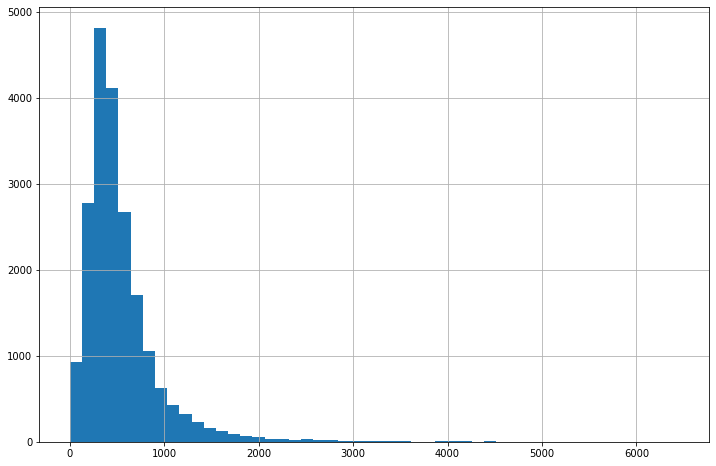

In [22]:
total_bedroms = data[data["total_bedrooms"].notnull()]["total_bedrooms"]
total_bedroms.hist(figsize=(12,8),bins=50)
plt.show()

<div style="display: flex; background-color: coral;" >

### 3.2.5. ```'total_bedrooms'``` > Polynomiale Feature avec plusieurs features
</div>

Faire une régression polynomiale avec plusieurs critères, car total_bedroom est très corrélée aux features :
* ```'total_rooms'```
* ```'households'```
* ```'population'```

Version PolynomialFeature

In [23]:
data_encode["bed_room_on_poly2"] = data_encode['total_bedrooms']

In [24]:
X = data_encode.loc[data_encode['bed_room_on_poly2'].notna(),['total_rooms', 'population', 'households']]
y = data_encode.loc[data_encode['bed_room_on_poly2'].notna(),['total_bedrooms']]

X_pred = data_encode.loc[(data_encode['bed_room_on_poly2'].isna()),['total_rooms', 'population', 'households']]

In [25]:
pf=PolynomialFeatures(degree=2,include_bias=False)
Xpf= pf.fit_transform(X)

linreg = LinearRegression()
linreg.fit(Xpf,y)
print(linreg.score(Xpf, y))

X_pred_poly = pf.fit_transform(X_pred)
y_pred2 = linreg.predict(X_pred_poly)

X_pred["y_pred"] = y_pred2
data_encode.loc[X_pred.index, 'bed_room_on_poly2'] = round(X_pred["y_pred"], 0)
data_encode.iloc[X_pred.index]


0.9785708466923002


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,bed_room_on_poly2
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0,241.0
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0,265.0
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0,1337.0
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0,166.0
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,0.0,0.0,0.0,0.0,1.0,787.0
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,0.0,0.0,0.0,0.0,1.0,789.0
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN,1.0,0.0,0.0,0.0,0.0,749.0
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN,1.0,0.0,0.0,0.0,0.0,883.0


Les 3 façons de prédire donnent des résultats différents.     
La méthode avec le meilleur score est Polynomiale avec les 3 colonnes, c'est donc cette valeur qui sera concervée

In [26]:
data_clean = data_encode[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN', 'bed_room_on_poly2']]

data_clean = data_clean.rename(columns={'bed_room_on_poly2':'total_bedrooms'})
data_clean = data_clean[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
       'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]
print(data_clean.shape)
data_clean.head()

(20640, 15)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0


<div style="display: flex; background-color: green;" >

## 3.3. Suppression de valeurs abérrentes
</div>

Certains ménages sont suppérieurs à la population, ce qui n'est pas logique.

Suppression des lignes concernées.

In [ ]:
df_origin[df_origin['households']>df_origin['population']]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5342,-118.44,34.04,16.0,18.0,6.0,3.0,4.0,0.5360,350000.0,<1H OCEAN
11849,-121.00,39.75,8.0,1116.0,214.0,27.0,39.0,2.5893,83000.0,INLAND
19522,-121.00,37.65,17.0,484.0,202.0,198.0,204.0,0.6825,187500.0,INLAND


In [27]:
data_clean = data_clean[data_clean['households']<data_clean['population']]
print("Suppression de :", df_origin.shape[0] - data_clean.shape[0], "lignes, soit :",data_clean.shape)

Suppression de : 3 lignes, soit : (20637, 15)


<div style="display: flex; background-color: blue;" >

# 4. Sélection des features
</div>


In [28]:
y = data_clean[target]

<div style="display: flex; background-color: coral;" >

### 4.2.1. Résultat avec les colonnes sélectionnées par SelectFromModel
</div>

Avec les colonnes sélectionnées par SelectFromModel : ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']

| Model               | Score (SelectFromModel)|Score (opti colonnes)   |Colonnes                                                          |
|---------------------|------------------------|------------------------|------------------------------------------------------------------|
|RandomForestRegressor|0.8149208433864923      |0.8256503330902139      |['latitude', 'longitude', 'median_income', 'ocean_proximity_NEAR OCEAN', 'population', 'total_rooms']{'randomforestregressor__n_estimators': 91}|
|Linear               |0.6375109203895848      |0.624968468123067       |['households', 'housing_median_age', 'median_income', 'ocean_proximity_INLAND', 'population', 'total_bedrooms']{'linearregression__fit_intercept': True, 'linearregression__normalize': False, 'linearregression__positive': True}|
|Ridge                |0.6369668147332046      |0.6249669368125365      |['households', 'housing_median_age', 'median_income', 'ocean_proximity_INLAND', 'population', 'total_bedrooms']{'ridge__alpha': 1, 'ridge__fit_intercept': True, 'ridge__solver': 'lsqr'}|
|Lasso                |0.5221268993459647      |0.6180058390312215      |['households', 'housing_median_age', 'median_income', 'ocean_proximity_INLAND', 'population', 'total_bedrooms']{'lassocv__alphas': None, 'lassocv__fit_intercept': True}|
|KNeighborsRegressor  |0.306635596696181       |0.7861064663157169      |['latitude', 'longitude']{'kneighborsregressor__n_neighbors': 19}|
|SGDRegressor         |0.12727491738581131     |0.5849056187242465      |['housing_median_age', 'latitude', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY']{'sgdregressor__fit_intercept': True, 'sgdregressor__loss': 'squared_error', 'sgdregressor__penalty': 'l2'}|


In [30]:
selected_columns = get_numeric_columns_names(data_clean)
selected_columns.remove(target)

select_from_VarianceThreshold= ['longitude', 'latitude', 'housing_median_age', 'total_rooms','total_bedrooms', 'population', 'households', 'median_income']
select_from_model = ['latitude', 'longitude', 'median_income', 'ocean_proximity_NEAR OCEAN', 'population', 'total_rooms']

selected_columns = select_from_model

selected_columns

['latitude',
 'longitude',
 'median_income',
 'ocean_proximity_NEAR OCEAN',
 'population',
 'total_rooms']

In [31]:
X = data_clean[selected_columns]
X.columns

Index(['latitude', 'longitude', 'median_income', 'ocean_proximity_NEAR OCEAN',
       'population', 'total_rooms'],
      dtype='object')

<div style="display: flex; background-color: blue;" >

# 5. Modelling
</div>


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

try:
    from sklearn.utils._testing import ignore_warnings
except ImportError:
    from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [34]:
random_state=0

# On prend uniquement les colonnes qui nous intéresse (identifiée précédemment)
X_train, X_test, y_train, y_test = train_test_split(X[selected_columns], y, test_size=0.3, random_state=random_state)

<div style="display: flex; background-color: green;" >

## 5.1. Optimisation des paramétrages
</div>

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [ ]:
models_list = { }

In [ ]:
grid_linear = get_models_regression_linear_grid(X_train, y_train, verbose=verbose)
score_linear = grid_linear.score(X_test, y_test)
print("Linear :", score_linear)
models_list["Linear"] = grid_linear
print(grid_linear.best_params_)

Linear : 0.5858791186911092
{'linearregression__fit_intercept': True, 'linearregression__normalize': True, 'linearregression__positive': False}


In [36]:
grid_params={ 'randomforestregressor__n_estimators' : np.arange(1, 100, 10)}
grid_params = { 'randomforestregressor__n_estimators' : [91],
                        'randomforestregressor__max_features' : ['auto', 'sqrt']
                        }
grid_forest = get_models_regression_random_forest(X_train, y_train, verbose=verbose, grid_params=grid_params)
score_forest = grid_forest.score(X_test, y_test)
print("Forest :", score_forest)
models_list["Forest"] = grid_forest
print(grid_forest.best_params_)

Forest : 0.8256368989269849
{'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 91}


In [38]:
for model_name, model_grid in models_list.items():
    print(model_name, " "*(18-len(model_name)), ":", model_grid.score(X_test, y_test), " "*2, model_grid.best_params_)

Forest              : 0.8256368989269849    {'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 91}
HuberRegressor      : 0.4786801812402993    {'huberregressor__fit_intercept': False}


<div style="display: flex; background-color: green;" >

## 5.2. Evaluation
</div>

In [ ]:
from sklearn.metrics import *

In [ ]:
dict_error = {}
dict_y_pred = {}
for model_name, model_grid in models_list.items():
    y_pred = model_grid.predict(X_test)
    print(model_name.replace(" score", ""), " "*(18-len(model_name)), "=>", end="")
    print(" R2 :", round(model_grid.score(X_test, y_test),3), end="")
    print(", MAE :", round(mean_absolute_error(y_test, y_pred),3), end="")
    mse = mean_squared_error(y_test, y_pred)
    print(", MSE :", round(mse,3), end="")
    print(", RMSE :", round(np.sqrt(mse),3), end="")
    print(", Median AE: ", round(median_absolute_error(y_test, y_pred),3))
    dict_error[model_name] = np.abs(y_test - y_pred)
    dict_y_pred[model_name] =  y_pred 

Lasso               => R2 : 1.0, MAE : 91.296, MSE : 13289.368, RMSE : 115.28, Median AE:  76.549
Linear              => R2 : 1.0, MAE : 0.0, MSE : 0.0, RMSE : 0.0, Median AE:  0.0
Ridge               => R2 : 1.0, MAE : 0.0, MSE : 0.0, RMSE : 0.0, Median AE:  0.0
SGDRegressor        => R2 : -2.4498384279180864e+26, MAE : 1.599470761064061e+18, MSE : 3.255566250532861e+36, RMSE : 1.8043187774151388e+18, Median AE:  1.4052592439067648e+18
KNeighborsRegressor  => R2 : 1.0, MAE : 125.487, MSE : 70587.303, RMSE : 265.683, Median AE:  71.429
Forest              => R2 : 1.0, MAE : 21.317, MSE : 4756.045, RMSE : 68.964, Median AE:  6.173
HuberRegressor      => R2 : 1.0, MAE : 0.015, MSE : 0.0, RMSE : 0.019, Median AE:  0.014


Résultat

* MSE = Mean Squared Error : vous accordez une grande importance aux grandes erreurs
* MAE = Mean Absolute Error : l'importance d'une erreur est linéaire avec son amplitude. Si le dataset contient des outliers
* RMSE = Root Mean Squared Error : Remise à l'échelle, donc racine carré de MSE
* R2 = Coefficient de Détermination
* Median Absolute Error : très peu sensible aux outliers


|Modèle               |R2           |MAE        |MSE         |RMSE         |Media AE     |
|---------------------|-------------|-----------|------------|-------------|-------------|
|Lasso                | 1.0         | 91.296    | 13289.368  | 115.28      | 76.549      |
|Linear               | 1.0,        | 0.0       | 0.0        | 0.0         | 0.0         |
|Ridge                | 1.0,        | 0.0       | 0.0        | 0.0         | 0.0         |
|SGDRegressor         | -2.44..e+26 | 1.59..e+18|3.2555..e+36|1.8031..e+18 | 1.405...e+18|
|KNeighborsRegressor  | 1.0         | 125.487   | 70587.303  | 265.683     | 71.429      |
|Forest               | 1.0         | 21.317    | 4756.045   | 68.964      | 6.173       |
|HuberRegressor       | 1.0         | 0.015     | 0.0        | 0.019       | 0.014       |

<div style="display: flex; background-color: green;" >

## 5.3. Représentation des différentes erreurs
</div>

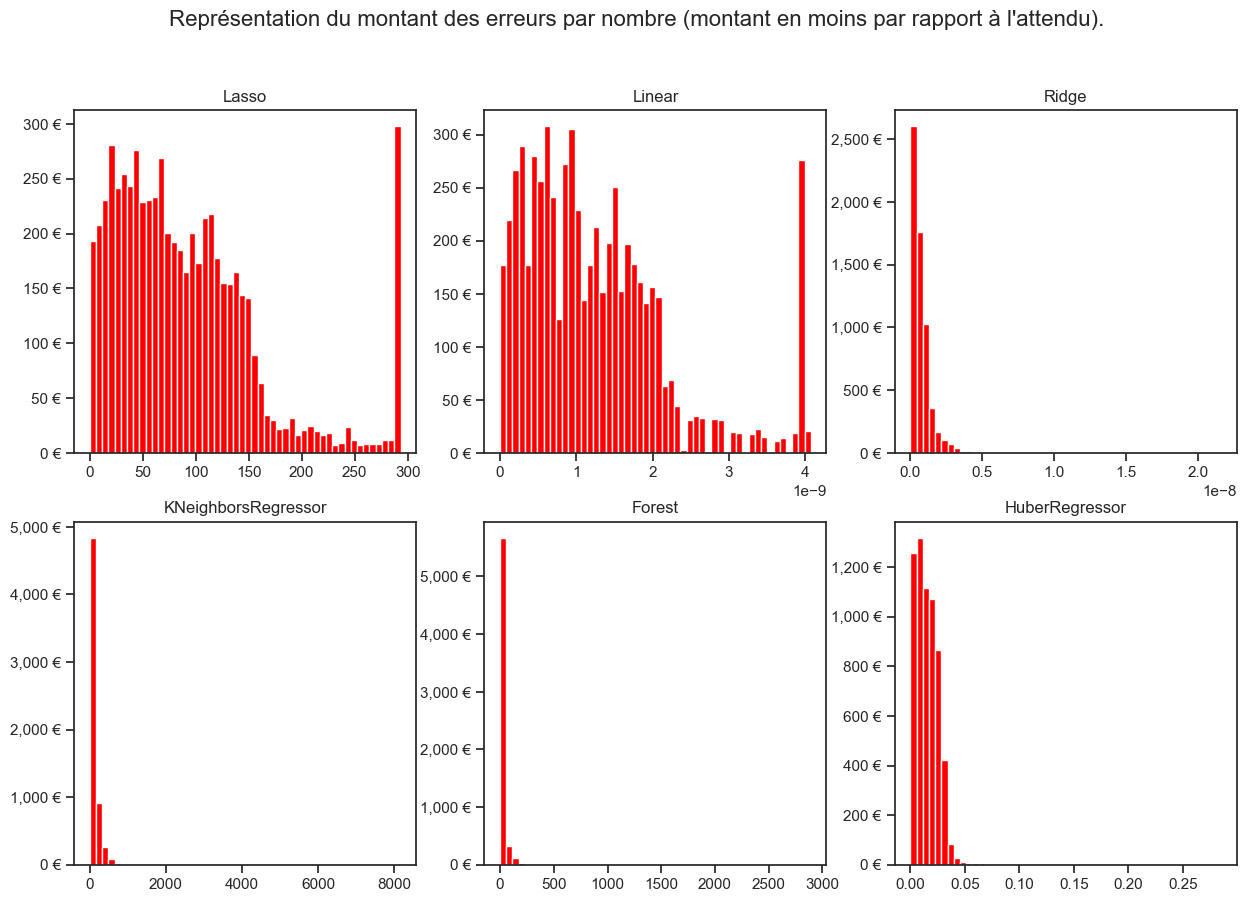

In [ ]:
figure, axes = color_graph_background(1,2)

nb_model = len(dict_error.keys())
nb_col = nb_model
if nb_col > 3:
    nb_col = 3
    nb_line = nb_model / nb_col
    
figure, axes = color_graph_background(nb_line,nb_col)

i=0
j=0

for model_name, err_hist in dict_error.items():
    if "SGDRegressor" in model_name:
        continue
    else:
        axe = axes[i][j]
        axe.hist(err_hist, bins=50, color='red')
        axe.set_title(model_name)
        axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f} €". format(x)))
        j += 1
        if j == nb_col:
            j = 0
            i += 1
figure.suptitle("Représentation du montant des erreurs par nombre (montant en moins par rapport à l'attendu).", fontsize=16)
figure.set_size_inches(15, 5*2, forward=True)
figure.set_dpi(100)
plt.show()

<div style="display: flex; background-color: green;" >

## 6.3. Représentation des valeurs de Y
</div>

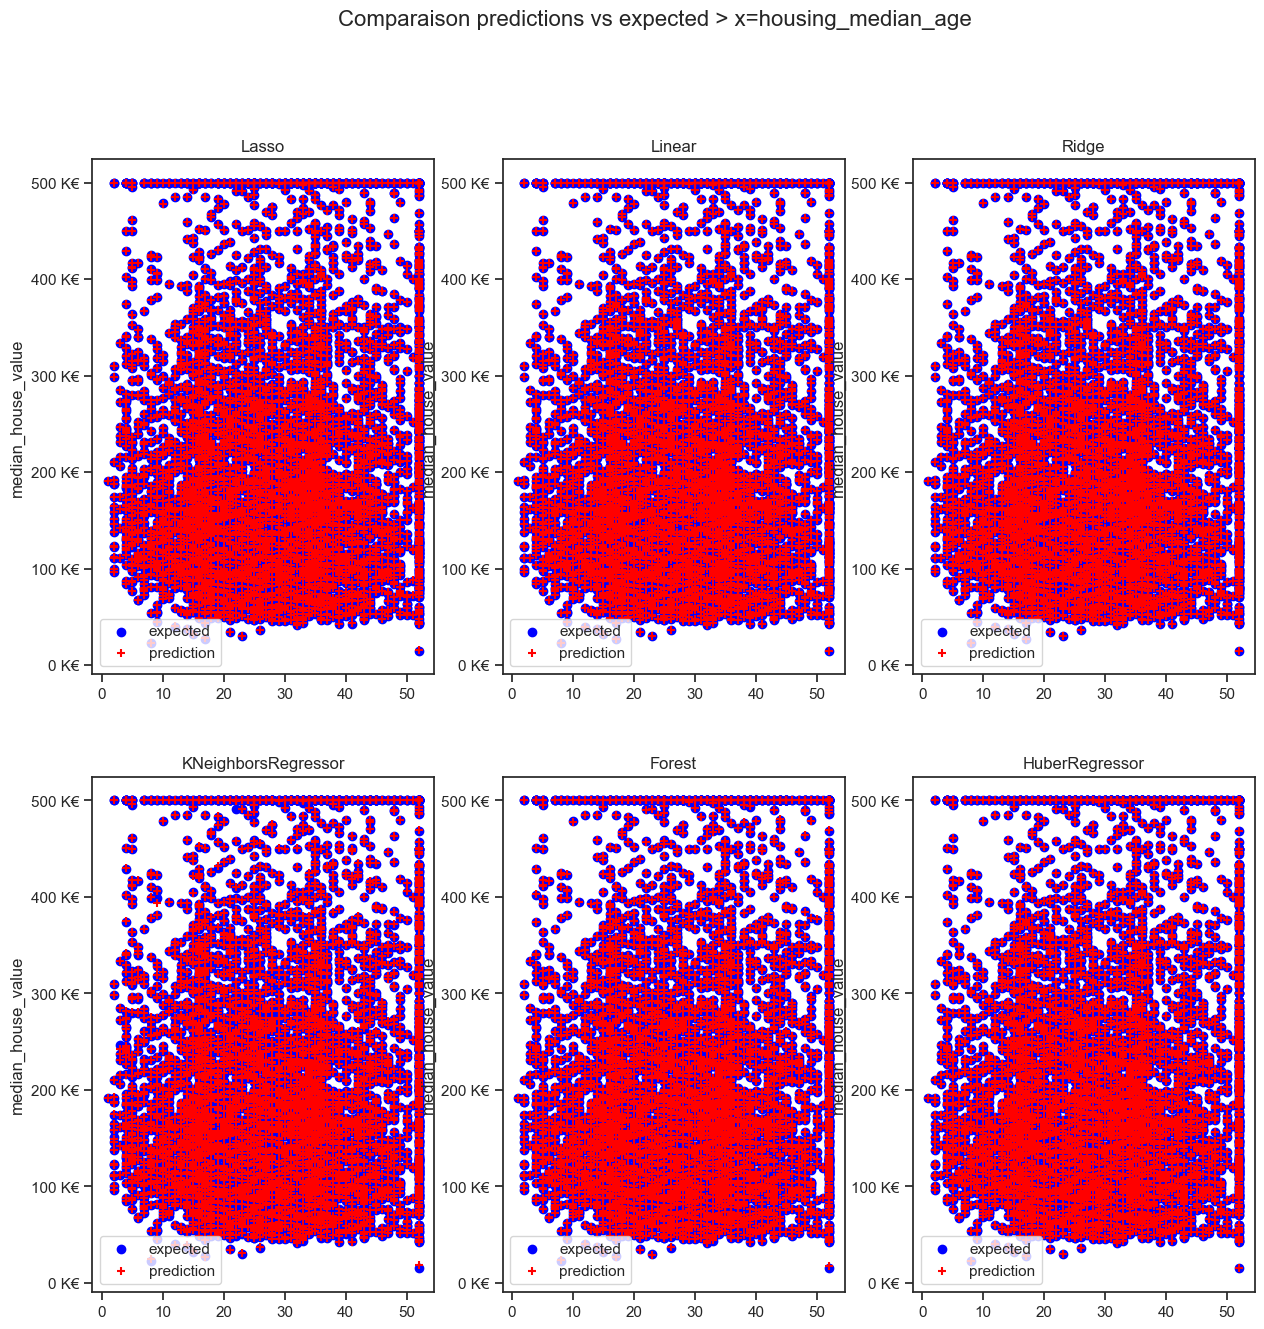

In [ ]:
draw_y(X_test, 'housing_median_age', y_test, y_pred, dict_y_pred)

<div style="display: flex; background-color: green;" >

## 6.5. Learning Curve
</div>

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
# le traitement pour le learning Curve étant long environ 24 min, il est préférable de le lancer manuellement si souhaité
just to fail

SyntaxError: invalid syntax (Temp/ipykernel_9092/201294292.py, line 1)

Lasso  Full :                 [ 1547  3095  4643  6190  7738  9286 10833 12381 13929 15477]
Lasso  train :                 [ 1083  2166  3249  4333  5416  6499  7583  8666  9749 10833]
Linear  Full :                [ 1547  3095  4643  6190  7738  9286 10833 12381 13929 15477]
Linear  train :                [ 1083  2166  3249  4333  5416  6499  7583  8666  9749 10833]
Ridge  Full :                 [ 1547  3095  4643  6190  7738  9286 10833 12381 13929 15477]
Ridge  train :                 [ 1083  2166  3249  4333  5416  6499  7583  8666  9749 10833]
SGDRegressor  Full :          [ 1547  3095  4643  6190  7738  9286 10833 12381 13929 15477]
SGDRegressor  train :          [ 1083  2166  3249  4333  5416  6499  7583  8666  9749 10833]
KNeighborsRegressor  Full :   [ 1547  3095  4643  6190  7738  9286 10833 12381 13929 15477]
KNeighborsRegressor  train :   [ 1083  2166  3249  4333  5416  6499  7583  8666  9749 10833]
Forest  Full :                [ 1547  3095  4643  6190  7738  9286 10833 12

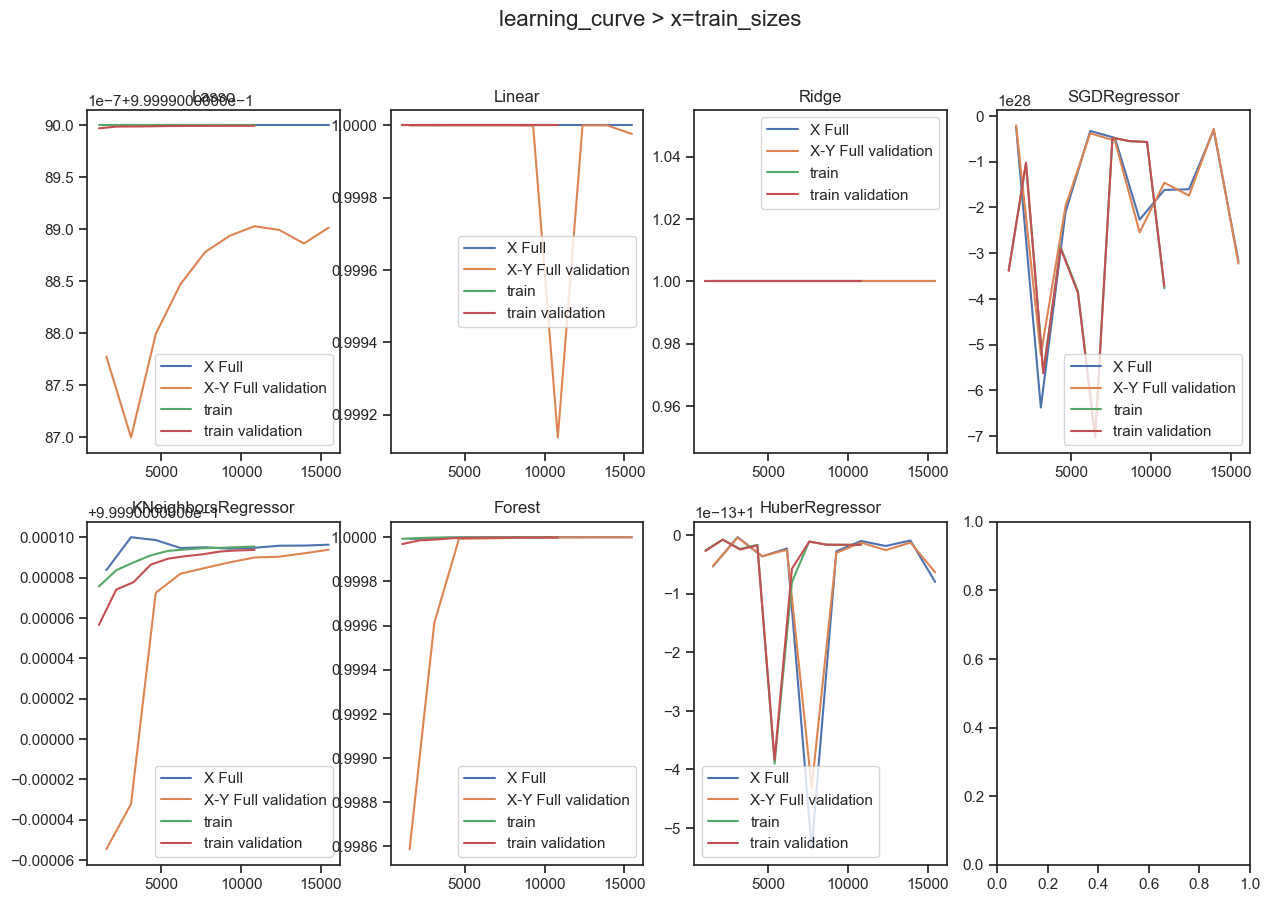

In [ ]:
figure, axes = color_graph_background(2,4)

nb_model = len(models_list.keys())
nb_col = nb_model
if nb_col > 3:
    nb_col = 3
    nb_line = nb_model / nb_col

train_sizes=np.linspace(0.1, 1, 10)
cv=4

i=0
j=0

for model_name, model_grid in models_list.items():

    axe = axes[i][j]
    N, train_score, val_score = learning_curve(model_grid, X, y,
                                            train_sizes=train_sizes, cv=cv)
    axe.plot(N, train_score.mean(axis=1), label='X Full')
    axe.plot(N, val_score.mean(axis=1), label='X-Y Full validation')
    print(model_name, " Full : ", " "*(20-len(model_name)), N)
    
    N, train_score, val_score = learning_curve(model_grid, X_train, y_train,
                                            train_sizes=train_sizes, cv=cv)
    axe.plot(N, train_score.mean(axis=1), label='train')
    axe.plot(N, val_score.mean(axis=1), label='train validation')
    print(model_name, " Train :", " "*(20-len(model_name)), N)

    axe.legend()
    axe.set_title(model_name)
    j += 1
    if j == 4:
        j = 0
        i += 1
figure.set_size_inches(15, 5*2, forward=True)
figure.set_dpi(100)
figure.suptitle('learning_curve > x=train_sizes', fontsize=16)
plt.show()

 <div style="display: flex; background-color: blue;" >

# 6. Conclusions
</div>
 La régression linéaire fait plus d'erreurs que le modèle Ridge, mais le montant d'erreur est plus faible.
 Le choix du modèle dépend donc de notre "préférence"

 <div style="display: flex; background-color: blue;" >

# 7. Pour l'exercice (hors solution retenue)
</div>


- [x] Importer les bibliothèques adéquates.
- [x] Importer le jeu de données.
- [x] Découvrez et visualisez les données pour obtenir des informations
- [x] Imputation (SimpleImputer). Cf. Annexe
- [x] Encoder les valeurs catégoriques (OneHotEncoder).
- [x] Fractionner le jeu de données pour l’entrainement et le test (Training and Test set).
- [x] Mise à l’échelle des features (StandardScaler). Cf. Annexe
- [x] Pipelines (cf. fichier function.py)
- [x] Grid Search
- [x] Évaluez votre système sur l'ensemble de test


Il reste donc la partie Mise à l'échelle, qui va être faite ci-dessous pour l'excercice.

In [40]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [41]:
x_cols = list(X.columns)
x_cols

['latitude',
 'longitude',
 'median_income',
 'ocean_proximity_NEAR OCEAN',
 'population',
 'total_rooms']

<div style="display: flex; background-color: green;" >

## 7.1. RobustScaler
</div>
Utilisation de RobustScaler par rapport aux outliers

In [42]:
# Utilisation de RobustScaler du fait des outliers toujours présents
X_robust = RobustScaler().fit_transform(X)
X_robust

array([[ 0.95767196, -0.98680739,  2.19754106,  0.        , -0.89978678,
        -0.73352941],
       [ 0.95238095, -0.98416887,  2.18662263,  0.        ,  1.31663113,
         2.92470588],
       [ 0.94973545, -0.98944591,  1.7076796 ,  0.        , -0.71428571,
        -0.38823529],
       ...,
       [ 1.36772487, -0.72031662, -0.84182035,  0.        , -0.16950959,
         0.07470588],
       [ 1.36772487, -0.74670185, -0.76511607,  0.        , -0.45309168,
        -0.15705882],
       [ 1.35185185, -0.72559367, -0.52591981,  0.        ,  0.23560768,
         0.38705882]])

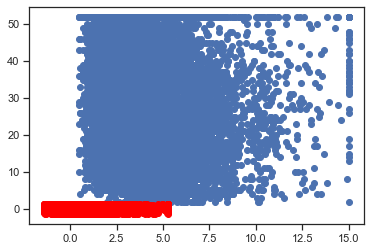

In [ ]:
plt.scatter(X[['median_income']], X[['housing_median_age']])
plt.scatter(X_robust[:,x_cols.index('median_income')], X_robust[:,x_cols.index('housing_median_age')], color='red')

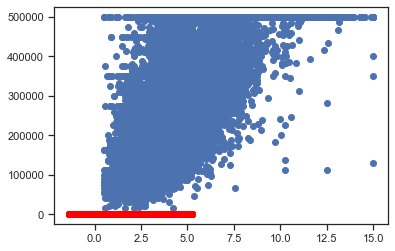

In [ ]:
plt.scatter(X[['median_income']], X[['median_house_value']])
plt.scatter(X_robust[:,x_cols.index('median_income')], X_robust[:,x_cols.index('median_house_value')], color='red')

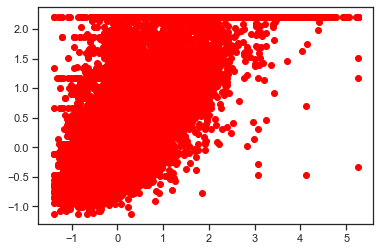

In [ ]:
plt.scatter(X_robust[:,x_cols.index('median_income')], X_robust[:,x_cols.index('median_house_value')], color='red')

In [43]:
# On prend uniquement les colonnes qui nous intéresse (identifiée précédemment)
X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(X_robust, y, test_size=0.3, random_state=random_state)

In [45]:
grid_params={ 'randomforestregressor__n_estimators' : np.arange(1, 100, 10)}
grid_params = { 'randomforestregressor__n_estimators' : np.arange(1, 100, 10),
                        'randomforestregressor__max_features' : ['auto', 'sqrt']
                        }
grid_forest = get_models_regression_random_forest(X_train_robust, y_train_robust, verbose=verbose, grid_params=grid_params)
score_forest = grid_forest.score(X_test, y_test)
print("Forest :", score_forest)
models_list["ForestRobust"] = grid_forest
print(grid_forest.best_params_)

Forest : -1.6460884824820283
{'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 91}


In [46]:
grid_ridge_robust = get_models_regression_ridge_grid(X_train_robust, y_train_robust, verbose=verbose)
score_ridge_robust = grid_ridge_robust.score(X_test_robust, y_test_robust)
print("Ridge Robust :", score_ridge_robust)
print(grid_ridge_robust.best_params_)

Ridge Robust : 0.5858966199351159
{'ridge__alpha': 1, 'ridge__fit_intercept': True, 'ridge__solver': 'sag'}


In [ ]:
grid_linear_robust = get_models_regression_linear_grid(X_train_robust, y_train_robust, verbose=verbose)
score_linear_robust = grid_linear_robust.score(X_test_robust, y_test_robust)
print("Linear Robust :", score_linear_robust)
print(grid_linear_robust.best_params_)

Linear Robust : 1.0
{'linearregression__fit_intercept': True, 'linearregression__normalize': True, 'linearregression__positive': True}


<div style="display: flex; background-color: green;" >

## 7.2. StandardScaler
</div>
Utilisation de StandardScaler pour le test

In [47]:
X_stdscl = StandardScaler().fit_transform(X)

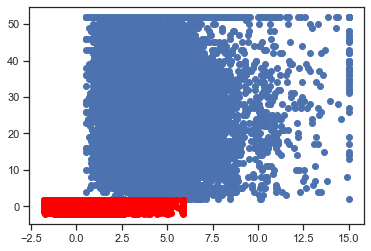

In [ ]:
plt.scatter(X[['median_income']], X[['housing_median_age']])
plt.scatter(X_stdscl[:,x_cols.index('median_income')], X_stdscl[:,x_cols.index('housing_median_age')], color='red')

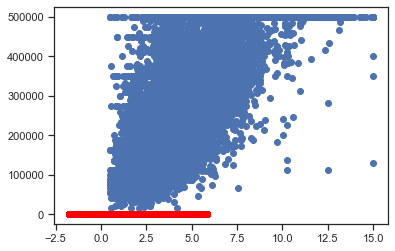

In [ ]:
plt.scatter(X[['median_income']], X[['median_house_value']])
plt.scatter(X_stdscl[:,x_cols.index('median_income')], X_stdscl[:,x_cols.index('median_house_value')], color='red')

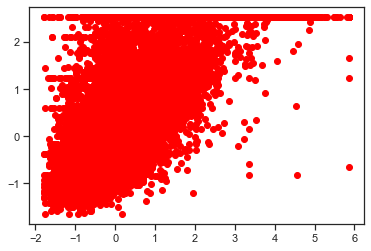

In [ ]:
plt.scatter(X_stdscl[:,x_cols.index('median_income')], X_stdscl[:,x_cols.index('median_house_value')], color='red')

In [48]:
# On prend uniquement les colonnes qui nous intéresse (identifiée précédemment)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_stdscl, y, test_size=0.3, random_state=random_state)

In [49]:
grid_params={ 'randomforestregressor__n_estimators' : np.arange(1, 100, 10)}
grid_params = { 'randomforestregressor__n_estimators' : [91],
                        'randomforestregressor__max_features' : ['auto', 'sqrt']
                        }
grid_forest = get_models_regression_random_forest(X_train_robust, y_train_robust, verbose=verbose, grid_params=grid_params)
score_forest = grid_forest.score(X_test, y_test)
print("Forest :", score_forest)
models_list["Foreststdscl"] = grid_forest
print(grid_forest.best_params_)

Forest : -1.6460884824820283
{'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 91}


In [50]:
grid_ridge_std = get_models_regression_ridge_grid(X_train_std, y_train_std, verbose=verbose)
score_ridge_std = grid_ridge_std.score(X_test_std, y_test_std)
print("Ridge STD :", score_ridge_std)
print(grid_ridge_std.best_params_)

Ridge STD : 0.585885000861903
{'ridge__alpha': 1, 'ridge__fit_intercept': True, 'ridge__solver': 'saga'}


In [ ]:
grid_linear_std = get_models_regression_linear_grid(X_train_std, y_train_std, verbose=verbose)
score_linear_std = grid_linear_std.score(X_test_std, y_test_std)
print("Linear STD :", score_linear_std)
print(grid_linear_std.best_params_)

Linear STD : 1.0
{'linearregression__fit_intercept': True, 'linearregression__normalize': False, 'linearregression__positive': True}


<div style="display: flex; background-color: grey;" >

# ANNEXES / ARCHIVES--------------------------------------------------
</div>


In [ ]:
just to fail pour ne pas exécuter le code des cellules suivantes et garder leur sortie respective

SyntaxError: invalid syntax (Temp/ipykernel_8848/693838000.py, line 1)

<div style="display: flex; background-color: green;" >

## A.X. Selection des features
</div>

<div style="display: flex; background-color: coral;" >

### A.4.1. Variance Threshold
</div>

In [ ]:
from sklearn.feature_selection import VarianceThreshold
numeric_col = get_numeric_columns_names(data_clean)
numeric_col.remove(target)
numeric_col

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [ ]:
X = data_clean[numeric_col]
X.var(axis=0)

longitude                     4.014463e+00
latitude                      4.561814e+00
housing_median_age            1.583843e+02
total_rooms                   4.759469e+06
total_bedrooms                1.776314e+05
population                    1.282391e+06
households                    1.461709e+05
median_income                 3.608736e+00
ocean_proximity_<1H OCEAN     2.467231e-01
ocean_proximity_INLAND        2.166468e-01
ocean_proximity_ISLAND        2.422363e-04
ocean_proximity_NEAR BAY      9.865713e-02
ocean_proximity_NEAR OCEAN    1.122144e-01
dtype: float64

In [ ]:
selector = VarianceThreshold(threshold=2)
selector.fit(X)
np.array(numeric_col)[selector.get_support()]

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='<U26')

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [ ]:
# Nous devons supprimer les coordonnées
numeric_col_chi2 = numeric_col.copy()
numeric_col_chi2.remove('longitude')
numeric_col_chi2.remove('latitude')
numeric_col_chi2
Xchi2 = X[numeric_col_chi2]
print(Xchi2.shape, y.shape)
chi2(Xchi2, y)
# Tableau 1 score du tests stat, + il est grand, + il y a un lien avec target
# 2ème tableau P values
# Ce tableau est utilisé pour le SelectKBest

(20637, 11) (20637,)


(array([2.31855916e+04, 9.76838916e+06, 1.41213754e+06, 3.98684970e+06,
        1.30328668e+06, 1.17140623e+04, 3.74635519e+03, 6.56532242e+03,
        1.82786698e+03, 4.07900182e+03, 3.99293854e+03]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 8.60199820e-001, 4.40023874e-147,
        1.00000000e+000, 3.80519225e-003, 4.28285920e-002]))

<div style="display: flex; background-color: coral;" >

### A.4.2. SelectKBest
</div>

In [ ]:
for i in range(1, (len(numeric_col)+1)):
    selector = SelectKBest(f_classif, k=i)
    selector.fit(X, y)
    #  print(selector.scores_)
    print(i, np.array(numeric_col)[selector.get_support()])

1 ['median_income']
2 ['median_income' 'ocean_proximity_INLAND']
3 ['median_income' 'ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND']
4 ['total_rooms' 'median_income' 'ocean_proximity_<1H OCEAN'
 'ocean_proximity_INLAND']
5 ['latitude' 'total_rooms' 'median_income' 'ocean_proximity_<1H OCEAN'
 'ocean_proximity_INLAND']
6 ['latitude' 'total_rooms' 'median_income' 'ocean_proximity_<1H OCEAN'
 'ocean_proximity_INLAND' 'ocean_proximity_NEAR BAY']
7 ['latitude' 'total_rooms' 'median_income' 'ocean_proximity_<1H OCEAN'
 'ocean_proximity_INLAND' 'ocean_proximity_NEAR BAY'
 'ocean_proximity_NEAR OCEAN']
8 ['latitude' 'total_rooms' 'households' 'median_income'
 'ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_NEAR BAY' 'ocean_proximity_NEAR OCEAN']
9 ['latitude' 'total_rooms' 'population' 'households' 'median_income'
 'ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_NEAR BAY' 'ocean_proximity_NEAR OCEAN']
10 ['latitude' 'total_rooms' 'total_bedroo

<div style="display: flex; background-color: coral;" >

### A.4.3. SelectFromModel
</div>

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV

model_SVR = SVR( kernel = 'linear' , gamma = 'auto')

# Sélection des features pour le model SVR
selector_svr = SelectFromModel(model_SVR, threshold='mean')
selector_svr.fit(X, y)
selector_svr.estimator_.coef_
print(np.array(numeric_col)[selector_svr.get_support()])

['latitude' 'median_income' 'ocean_proximity_<1H OCEAN'
 'ocean_proximity_INLAND']


<div style="display: flex; background-color: coral;" >

### A.4.3. RFECV
</div>

Testes les features intéressantes pour le model SVR

In [ ]:
selector_rfecv = RFECV(model_SVR, step=1, min_features_to_select=4, cv=4)
selector_rfecv.fit(X, y)
# print(selector_rfecv.ranking_)
# print(selector_rfecv.cv_results_)
selected_columns= np.array(numeric_col)[selector_rfecv.get_support()]
print(selected_columns)
# colonnes sélectionnées : 
# ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','ocean_proximity_<1H OCEAN','ocean_proximity_INLAND' ,'ocean_proximity_NEAR BAY','ocean_proximity_NEAR OCEAN']

['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income'
 'ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_NEAR BAY' 'ocean_proximity_NEAR OCEAN']


<div style="display: flex; background-color: green;" >

## A.X. Tests pour trouver le meilleur modèle
</div>

In [ ]:
better_grid_score_dic, better_grid_equals = found_better_model(X_train, X_test, y_train, y_test, models_list, verbose=True)

Lasso score New Best :0.14 de test, ['housing_median_age', 'latitude', 'longitude', 'population', 'total_bedrooms', 'total_rooms'], {'lassocv__alphas': None, 'lassocv__fit_intercept': True}
Linear score New Best :0.37 de test, ['housing_median_age', 'latitude', 'longitude', 'population', 'total_bedrooms', 'total_rooms'], {'linearregression__fit_intercept': True, 'linearregression__normalize': False, 'linearregression__positive': False}
Ridge score New Best :0.37 de test, ['housing_median_age', 'latitude', 'longitude', 'population', 'total_bedrooms', 'total_rooms'], {'ridge__alpha': 1, 'ridge__fit_intercept': True, 'ridge__solver': 'sparse_cg'}
SGDRegressor score New Best :0.1 de test, ['housing_median_age', 'latitude', 'longitude', 'population', 'total_bedrooms', 'total_rooms'], {'sgdregressor__fit_intercept': False, 'sgdregressor__loss': 'epsilon_insensitive', 'sgdregressor__penalty': 'l1'}
Forest score New Best :0.8 de test, ['housing_median_age', 'latitude', 'longitude', 'population

In [ ]:
better_models = {}
# Affichage des meilleures configurations et colonnes
for k in better_grid_equals.keys():
    v = better_grid_equals[k]
    str_cols = ""
    params = None
    print(k, ":", better_grid_score_dic[k])
    for val in v:
        if val[-1].count(',')> str_cols.count(','):
            str_cols = val[-1]
            params = val[0]
        print(val[-1], end="")
        if isinstance(val[0], GridSearchCV):
            print(val[0].best_params_, end="")
        print("")
    better_models[k] = params,str_cols

Lasso score : 0.6180058390312215
['households', 'housing_median_age', 'median_income', 'ocean_proximity_INLAND', 'population', 'total_bedrooms']{'lassocv__alphas': None, 'lassocv__fit_intercept': True}
Linear score : 0.624968468123067
['households', 'housing_median_age', 'median_income', 'ocean_proximity_INLAND', 'population', 'total_bedrooms']{'linearregression__fit_intercept': True, 'linearregression__normalize': False, 'linearregression__positive': True}
Ridge score : 0.6249669368125365
['households', 'housing_median_age', 'median_income', 'ocean_proximity_INLAND', 'population', 'total_bedrooms']{'ridge__alpha': 1, 'ridge__fit_intercept': True, 'ridge__solver': 'lsqr'}
SGDRegressor score : 0.5849056187242465
['housing_median_age', 'latitude', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY']{'sgdregressor__fit_intercept': True, 'sgdregressor__loss': 'squared_error', 'sgdregressor__penalty': 'l2'}
Forest score : 0.8256503330902139
['latitude', 'longitude', 'media

In [ ]:
grid_params = { 'logisticregression__solver' : ["newton-cg", "lbfgs", "liblinear"],
                        'logisticregression__penalty' : ['l2'],
                        'logisticregression__fit_intercept' : [True]}
grid_logistic = get_models_regression_logistic_grid(X_train, y_train, verbose=verbose, grid_params=grid_params)
models_list["Logistic"] = grid_logistic
score_logistic = grid_logistic.score(X_test, y_test)
print("Logistic :", score_logistic)
print(grid_logistic.best_params_)

KeyboardInterrupt: 

In [ ]:
grid_forest_quantile = get_models_regression_outliers_robust_QuantileRegressor_grid(X_train, y_train, verbose=verbose)
score = grid_forest_quantile.score(X_test, y_test)
print("QuantileRegressor : ", score)
models_list["QuantileRegressor"] = grid_forest_quantile
print(grid_forest_quantile.best_params_)

In [ ]:
grid_knn_params = { 'kneighborsregressor__n_neighbors': np.arange(1, 20)}
grid_KNNRegressor = get_models_regression_knn_grid(X_train, y_train, verbose=verbose, grid_params=grid_knn_params)
score_KNNRegressor = grid_KNNRegressor.score(X_test, y_test)
print("KNeighborsRegressor :", score_KNNRegressor)
models_list["KNeighborsRegressor"] = grid_KNNRegressor
print(grid_KNNRegressor.best_params_)

KNeighborsRegressor : 0.21188968545802556
{'kneighborsregressor__n_neighbors': 19}
